In [39]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import daft

import scipy.stats as ss
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


Let's set up a simple hierarchical problem and then show how the various approaches to reweighting work for it.

Our simple problem is a set of (noisy) measurements of a quantity, $x$, whose population is Normal, with unknown mean:
$$
x \sim N\left( \mu, 1 \right),
$$
and we observe $x_\mathrm{obs}$ unbiasedly with uncertainty $1$:
$$
x_\mathrm{obs} \sim N \left( x , 1 \right).
$$

We have a set of observations, 
$$
D \equiv \left\{ x_\mathrm{obs}^{(i)} \mid i = 1, \ldots, N \right\}
$$
and we want to infer the values of $X = \left\{ x^{(i)} \mid x = 1, \ldots, N \right\}$ and $\mu$. 

The full posterior is 
$$
\pi \left( X, \mu \mid D \right) \propto \left[ \prod_{i = 1}^{N} N\left( x_\mathrm{obs} \mid x, 1\right) N\left( x \mid \mu, 1 \right) \right] p\left( \mu \right).
$$
From now on we will assume a flat prior on $\mu$ so that $p\left( \mu \right)$ is a constant.

If we just want to infer $\mu$, we can integrate over $X$ to derive 
$$
p\left( \mu \mid D \right) = \left[ \prod_{i=1}^{N} N\left( x_\mathrm{obs} \mid \mu, \sqrt{2} \right) \right] p\left( \mu \right) \propto N\left( \mu \mid \left\langle x_\mathrm{obs} \right\rangle, \sqrt{\frac{2}{N}} \right)
$$
This exploints that the Evidence for an observation of $x_\mathrm{obs}$ at fixed $\mu$ is 
$$
p\left( d^{(i)} \mid \mu \right) \equiv \int \mathrm{d} x \, N\left( x_\mathrm{obs}^{(i)} \mid x, 1 \right) N\left( x \mid \mu, 1 \right) = N\left( x_\mathrm{obs}^{(i)} \mid \mu, \sqrt{2} \right).
$$

The marginal distribution of $x^{(i)}$ is 
$$
p\left( x^{(i)} \mid D \right) = \int \mathrm{d} \mu \, \mathrm{d} \left( X \backslash \left\{ x^{(i)} \right\} \right) \, p\left( X, \mu \mid D \right) \propto N\left( x_\mathrm{obs}^{(i)} \mid x, 1 \right) N\left(x \mid \left\langle x_\mathrm{obs}^{\backslash (i)} \right\rangle, \sqrt{1 + \frac{2}{N-1}} \right)
$$

A graphical description of our model is:

<Figure size 433.62x433.62 with 0 Axes>

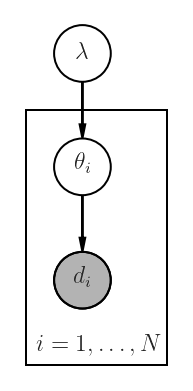

In [73]:
column_width = 433.62 / 72 # inches

with rc_context(rc={'figure.figsize': (column_width,column_width),
                    'text.usetex': True}):
    pgm = daft.PGM()

    pgm.add_node('lambda', r'$\lambda$', 0.5, 2.5)
    pgm.add_node('theta', r'$\theta_i$', 0.5, 1.5)
    pgm.add_node('d', r'$d_i$', 0.5, 0.5, observed=True)

    pgm.add_plate([0,-0.25, 1.25, 2.25], label=r'$i = 1, \ldots, N$')

    pgm.add_edge('lambda', 'theta')
    pgm.add_edge('theta', 'd')

    pgm.render()
    pgm.savefig('../note/pgm.pdf')

## The Dataset

In [2]:
np.random.randint(1<<32)

1443652990

In [19]:
mu_true = 0

N = 32
Nsamp = 1024
rstate = np.random.get_state()
try:
    np.random.seed(1443652990)
    x_true = np.random.normal(loc=mu_true, scale=1, size=N)
    x_obs = np.random.normal(loc=x_true, scale=1, size=N)
    x_likelihood = np.random.normal(loc=x_obs, scale=1, size=(Nsamp, N))
finally:
    np.random.set_state(rstate)

Text(0, 0.5, '$p\\left( x \\right)$')

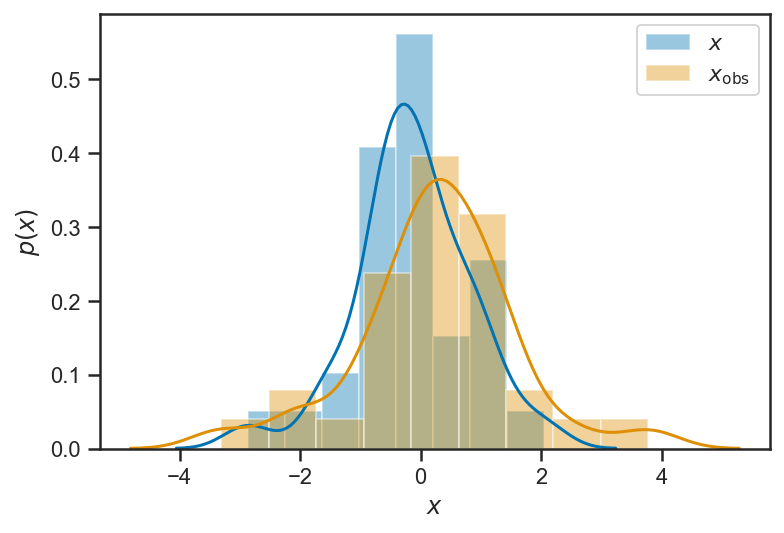

In [7]:
sns.distplot(x_true, label=r'$x$')
sns.distplot(x_obs, label=r'$x_\mathrm{obs}$')

legend(loc='best')

xlabel(r'$x$')
ylabel(r'$p\left( x \right)$')

## "Will's" Reweighting

In Will's suggested re-weighting scheme, we first draw samples of $\mu$ from the marginal posterior for $\mu$.  In more complicated problems we need to do this by MCMC sampling, but here we can draw directly:

Text(0, 0.5, '$p\\left( \\mu \\right)$')

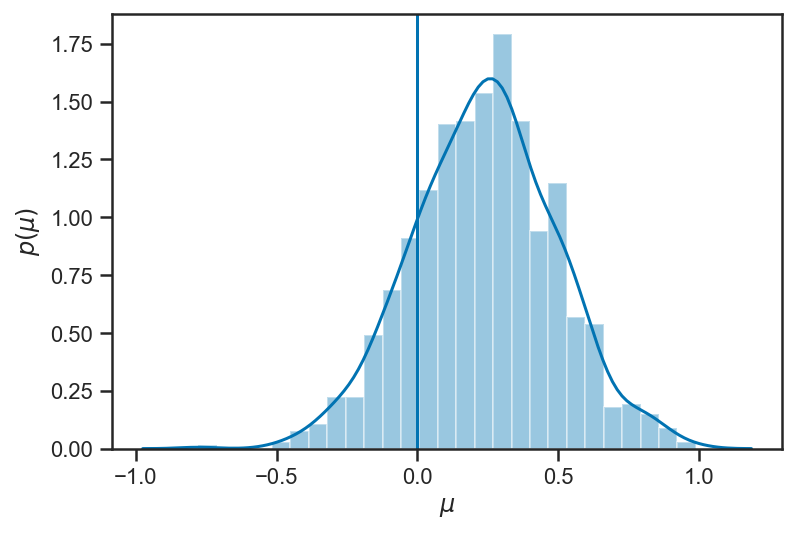

In [20]:
mu_samples = np.random.normal(loc=mean(x_obs), scale=sqrt(2/N), size=Nsamp)

sns.distplot(mu_samples)
axvline(0)
xlabel(r'$\mu$')
ylabel(r'$p\left( \mu \right)$')

Now, for each sample in $\mu$, we draw a sample for each of the $x$s from the conditional distribution
$$
x^{(i)} \sim N\left( x_\mathrm{obs}^{(i)} \mid x^{(i)}, 1 \right) N\left( x^{(i)} \mid \mu, 1 \right),
$$
which is equivalent to re-weighting the samples in the likelihood by the population distribution at that fixed value of $\mu$, and drawing a random one.

In [23]:
x_samples_will = []
for mu in mu_samples:
    wts = ss.norm(loc=mu, scale=1).pdf(x_likelihood)
    wts /= np.sum(wts, axis=0)
    
    x = []
    for j in range(wts.shape[1]):
        x.append(np.random.choice(x_likelihood[:,j], p=wts[:,j]))
    x_samples_will.append(x)
x_samples_will = array(x_samples_will)

Here is the distribution of $x^{(0)}$, and compare to the theoretical distribution:

Text(0, 0.5, '$p\\left( x^{(0)} \\right)$')

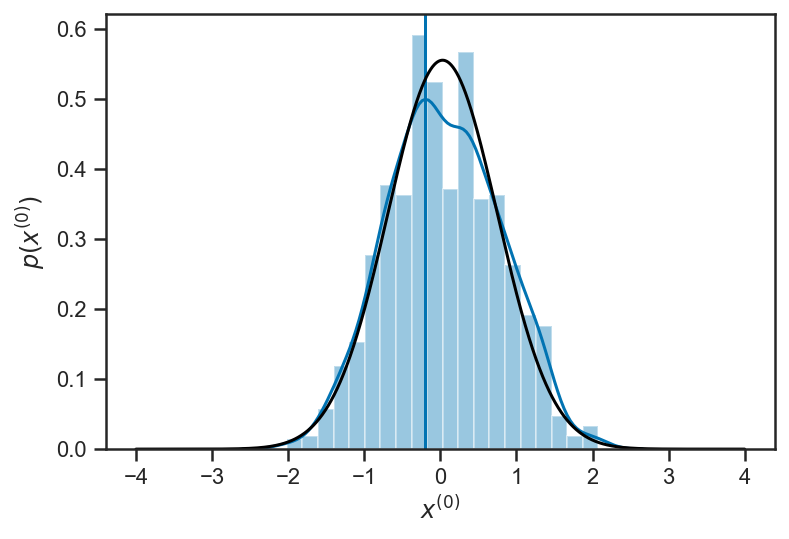

In [24]:
def x0_theoretical(xobs):
    mu_xminusi = mean(xobs[1:])
    
    xs = linspace(-4, 4, 2048)
    ps = ss.norm(loc=xs, scale=1).pdf(xobs[0])*ss.norm(loc=mu_xminusi, scale=sqrt(1 + 2/(N-1))).pdf(xs)
    ps /= trapz(ps, xs)
    
    return xs, ps

sns.distplot(x_samples_will[:,0])
axvline(x_obs[0])

xs, ps = x0_theoretical(x_obs)

plot(xs, ps, color='k', label='Theoretical')

xlabel(r'$x^{(0)}$')
ylabel(r'$p\left( x^{(0)} \right)$')

## Tom's Method

In Tom's method, in contrast, to draw samples for $x^{(i)}$, we compute a modified PPD:
$$
\tilde{p}\left( x^{(i)} \mid D \right) \equiv \int \mathrm{d} \mu \, p\left( x^{(i)} \mid \mu \right) \frac{p\left( \mu \mid D \right)}{p\left( d^{(i)} \mid \mu \right)}
$$
and use it to re-weight samples from the likelihood function.  

In [27]:
mu = mu_samples[:,newaxis]
modified_ppd_wts = ss.norm(loc=mean(x_obs), scale=sqrt(2/N)).pdf(mu)*ss.norm(loc=mu, scale=1).pdf(x_likelihood)/ss.norm(loc=mu, scale=sqrt(2)).pdf(x_obs[0])

modified_ppd_wts /= np.sum(modified_ppd_wts, axis=0)

x_samples_tom = []
for j in range(x_likelihood.shape[1]):
    x_samples_tom.append(np.random.choice(x_likelihood[:,j], p=modified_ppd_wts[:,j], size=Nsamp, replace=True))
x_samples_tom = array(x_samples_tom).T

Text(0, 0.5, '$p\\left( x^{(0)} \\right)$')

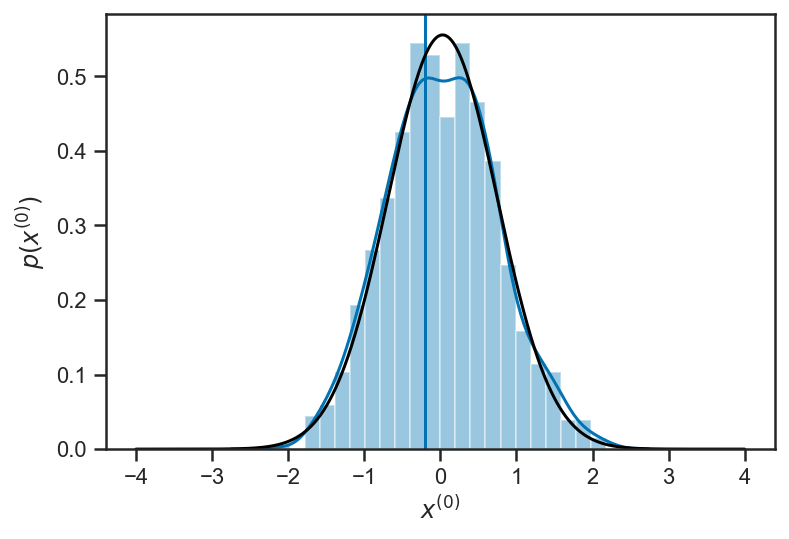

In [29]:
sns.distplot(x_samples_tom[:,0])

axvline(x_obs[0])

xs, ps = x0_theoretical(x_obs)

plot(xs, ps, color='k', label='Theoretical')

xlabel(r'$x^{(0)}$')
ylabel(r'$p\left( x^{(0)} \right)$')

## Let's Check if They Come from the Same Distribution

In [30]:
ss.ks_2samp(x_samples_will[:,0], x_samples_tom[:,0])

Ks_2sampResult(statistic=0.0390625, pvalue=0.4155294838847783)

Looks pretty good.